# Tissue Region Segmentation of IDC Slides with TIAToolbox

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/05_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

While [Notebook 04](04_patch_classification.ipynb) classified patches into tissue types, **semantic segmentation** provides pixel-level tissue classification, creating detailed maps of tissue regions.

In this notebook, we use TIAToolbox's `SemanticSegmentor` with the **FCN-ResNet50-UNet-BCSS** model to segment breast cancer tissue from an IDC slide into regions:

- Tumor
- Stroma
- Inflammatory infiltrate
- Necrosis
- Other

The model was trained on the [BCSS (Breast Cancer Semantic Segmentation)](https://bcsegmentation.grand-challenge.org/) dataset.

**GPU recommended** for faster inference.

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [ ]:
%%capture
%pip install "tiatoolbox==1.6.0" idc-index openslide-bin "numcodecs<0.16"

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from PIL import Image

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.semantic_segmentor import (
    SemanticSegmentor,
    IOSegmentorConfig,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    try:
        torch.zeros(1, device="cuda")
    except RuntimeError:
        print("CUDA available but not functional — falling back to CPU")
        device = "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Note: GPU is recommended. In Colab: Runtime > Change runtime type > T4 GPU")

  check_for_updates()



Using device: cuda


## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [ ]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 19:37:16 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 10.5 GB available
GPU:  Tesla T4, 15360 MiB, 580.82.07


## 1. Select and Download a Breast Cancer Slide

The BCSS model was trained on breast cancer tissue, so we'll select a slide from `tcga_brca` (TCGA Breast Invasive Carcinoma).

In [ ]:
idc_client = IDCClient()
idc_client.fetch_index("sm_index")

candidates = idc_client.sql_query("""
    SELECT
        i.SeriesInstanceUID,
        i.PatientID,
        ROUND(i.series_size_MB, 1) as size_mb,
        s.ObjectiveLensPower,
        s.max_TotalPixelMatrixColumns as width,
        s.max_TotalPixelMatrixRows as height,
        s.min_PixelSpacing_2sf as pixel_spacing_mm
    FROM sm_index s
    JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
    WHERE i.collection_id = 'tcga_brca'
        AND s.ObjectiveLensPower >= 20
    ORDER BY i.series_size_MB ASC
    LIMIT 5
""")

selected = candidates.iloc[0]
series_uid = selected['SeriesInstanceUID']
print(f"Selected: {selected['PatientID']}, {selected['size_mb']} MB")
print(f"  Dimensions: {selected['width']}x{selected['height']} @ {selected['ObjectiveLensPower']}x")

Selected: TCGA-A7-A26J, 18.2 MB
  Dimensions: 8618x7243 @ 40x


In [ ]:
download_dir = './slides'
os.makedirs(download_dir, exist_ok=True)

idc_client.download_from_selection(
    downloadDir=download_dir,
    seriesInstanceUID=[series_uid],
    dirTemplate='%SeriesInstanceUID'
)

slide_path = os.path.join(download_dir, series_uid)
reader = WSIReader.open(slide_path)

# DICOMWSIReader may not populate objective_power or mpp
info = reader.info
if info.objective_power is None:
    info.objective_power = float(selected['ObjectiveLensPower'])
if info.mpp is None:
    pixel_spacing_um = float(selected['pixel_spacing_mm']) * 1000
    info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])

thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
print(f"Opened: {type(reader).__name__}, dimensions: {info.slide_dimensions}")

Opened: DICOMWSIReader, dimensions: (8618, 7243)


## 2. Extract a Region of Interest

Running semantic segmentation on the entire slide can take a long time. For this tutorial, we'll extract a large tissue tile and run segmentation on that.

We find a tissue-rich region and extract a tile.

Extracted tile shape: (4096, 4096, 3)


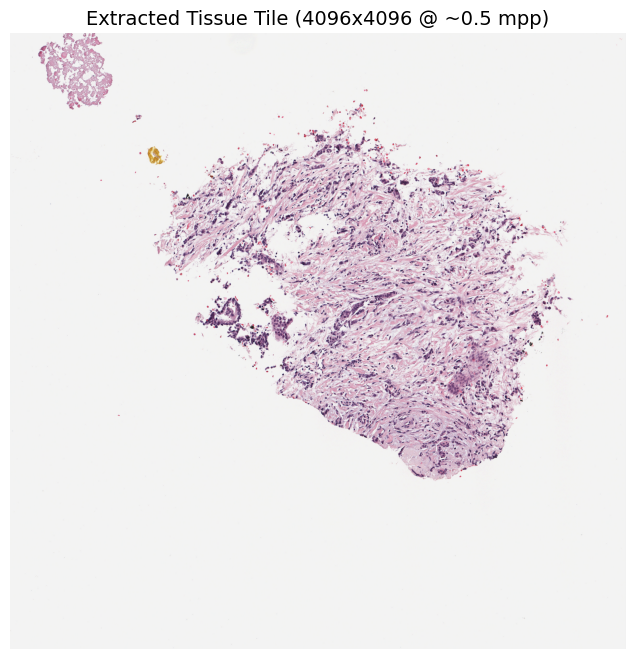

In [ ]:
# Find a tissue-rich region
gray = np.mean(thumbnail, axis=2)
tissue_mask = gray < 200
tissue_coords = np.argwhere(tissue_mask)

center_y, center_x = tissue_coords.mean(axis=0).astype(int)

slide_w, slide_h = info.slide_dimensions
baseline_x = int(center_x * slide_w / thumbnail.shape[1])
baseline_y = int(center_y * slide_h / thumbnail.shape[0])

# Extract a large tile (~4096x4096) in baseline coordinates
# DICOMWSIReader has coordinate issues at non-native resolutions,
# so we read at native resolution and resize if needed.
tile_size = 4096
baseline_mpp = float(info.mpp[0])
target_mpp = 0.5

# Compute how many baseline pixels correspond to tile_size at target_mpp
baseline_extent = int(tile_size * target_mpp / baseline_mpp)

bounds = (
    max(0, baseline_x - baseline_extent // 2),
    max(0, baseline_y - baseline_extent // 2),
    min(slide_w, baseline_x + baseline_extent // 2),
    min(slide_h, baseline_y + baseline_extent // 2),
)

tile = reader.read_bounds(
    bounds=bounds,
    resolution=info.objective_power,
    units="power",
)

# Resize to target tile size if native mpp differs from target
if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
    tile = np.array(Image.fromarray(tile).resize((tile_size, tile_size), Image.LANCZOS))

print(f"Extracted tile shape: {tile.shape}")

plt.figure(figsize=(8, 8))
plt.imshow(tile)
plt.title(f"Extracted Tissue Tile ({tile_size}x{tile_size} @ ~{target_mpp} mpp)", fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
# Save tile as a temporary image for the segmentor
tile_path = './tile_for_segmentation.png'
Image.fromarray(tile).save(tile_path)
print(f"Tile saved to {tile_path}")

Tile saved to ./tile_for_segmentation.png


## 3. Run Semantic Segmentation

The `SemanticSegmentor` processes images using a sliding window approach with configurable input/output resolutions and patch sizes.

In [ ]:
# Initialize the segmentor
segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    batch_size=4,
)

# BCSS class names
bcss_classes = ['Tumor', 'Stroma', 'Inflammatory', 'Necrosis', 'Other']
print(f"Model: fcn_resnet50_unet-bcss")
print(f"Classes: {bcss_classes}")

  saved_state_dict = torch.load(pretrained_weights, map_location="cpu")



Model: fcn_resnet50_unet-bcss
Classes: ['Tumor', 'Stroma', 'Inflammatory', 'Necrosis', 'Other']


In [ ]:
# Run segmentation on the tile
output = segmentor.predict(
    imgs=[tile_path],
    mode="tile",
    save_dir="./seg_results/",
    resolution=1.0,
    units="baseline",
    device=device,
)

print(f"Segmentation complete!")

Process Batch: 100%|############################| 64/64 [00:49<00:00,  1.28it/s]

Segmentation complete!


## 4. Visualize Segmentation Results

In [ ]:
# Load the segmentation result
seg_result = np.load(output[0][1] + '.raw.0.npy')
print(f"Segmentation result shape: {seg_result.shape}")

# Get class predictions (argmax over channels)
if seg_result.ndim == 3 and seg_result.shape[2] > 1:
    seg_map = np.argmax(seg_result, axis=2)
else:
    seg_map = seg_result.squeeze()

print(f"Segmentation map shape: {seg_map.shape}")
print(f"Unique classes: {np.unique(seg_map)}")

Segmentation result shape: (4096, 4096, 5)
Segmentation map shape: (4096, 4096)
Unique classes: [0 1 2 3 4]


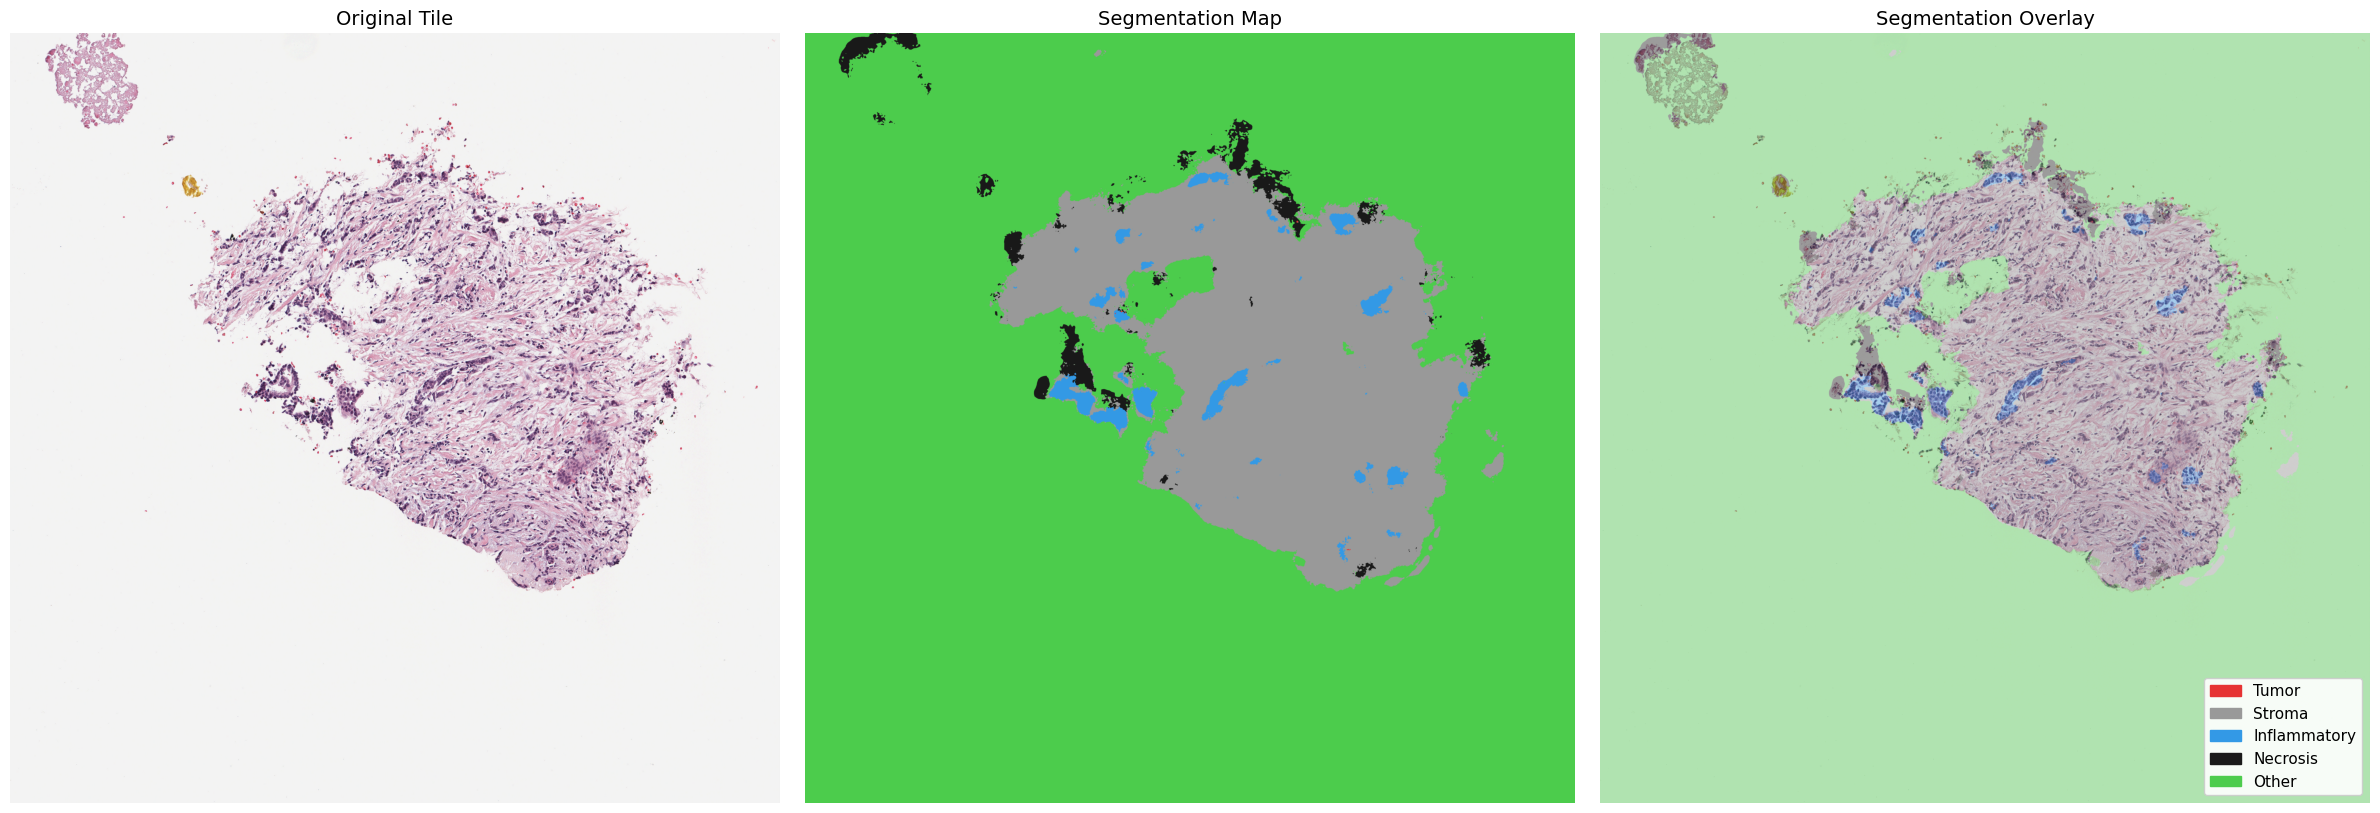

In [ ]:
# Define class colors
bcss_colors = {
    0: [0.9, 0.2, 0.2],   # Tumor - red
    1: [0.6, 0.6, 0.6],   # Stroma - gray
    2: [0.2, 0.6, 0.9],   # Inflammatory - blue
    3: [0.1, 0.1, 0.1],   # Necrosis - dark
    4: [0.3, 0.8, 0.3],   # Other - green
}

# Create colored segmentation map
seg_colored = np.zeros((*seg_map.shape, 3), dtype=np.float32)
for cls_id, color in bcss_colors.items():
    seg_colored[seg_map == cls_id] = color

# Resize to match tile dimensions if needed
from PIL import Image as PILImage
if seg_colored.shape[:2] != tile.shape[:2]:
    seg_colored_resized = np.array(
        PILImage.fromarray((seg_colored * 255).astype(np.uint8)).resize(
            (tile.shape[1], tile.shape[0]), PILImage.NEAREST
        )
    ) / 255.0
else:
    seg_colored_resized = seg_colored

# Create overlay
alpha = 0.4
overlay = alpha * seg_colored_resized + (1 - alpha) * tile / 255.0
overlay = np.clip(overlay, 0, 1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

axes[0].imshow(tile)
axes[0].set_title("Original Tile", fontsize=14)
axes[0].axis('off')

axes[1].imshow(seg_colored_resized)
axes[1].set_title("Segmentation Map", fontsize=14)
axes[1].axis('off')

axes[2].imshow(overlay)
axes[2].set_title("Segmentation Overlay", fontsize=14)
axes[2].axis('off')

# Add legend
legend_patches = [
    mpatches.Patch(color=bcss_colors[i], label=bcss_classes[i])
    for i in range(len(bcss_classes))
]
axes[2].legend(handles=legend_patches, loc='lower right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

## 5. Quantify Tissue Composition

Let's calculate what fraction of the tissue is composed of each type.

Tissue composition:
-----------------------------------
  Tumor          :    0.0%
  Stroma         :   18.3%
  Inflammatory   :    0.9%
  Necrosis       :    1.2%
  Other          :   79.5%


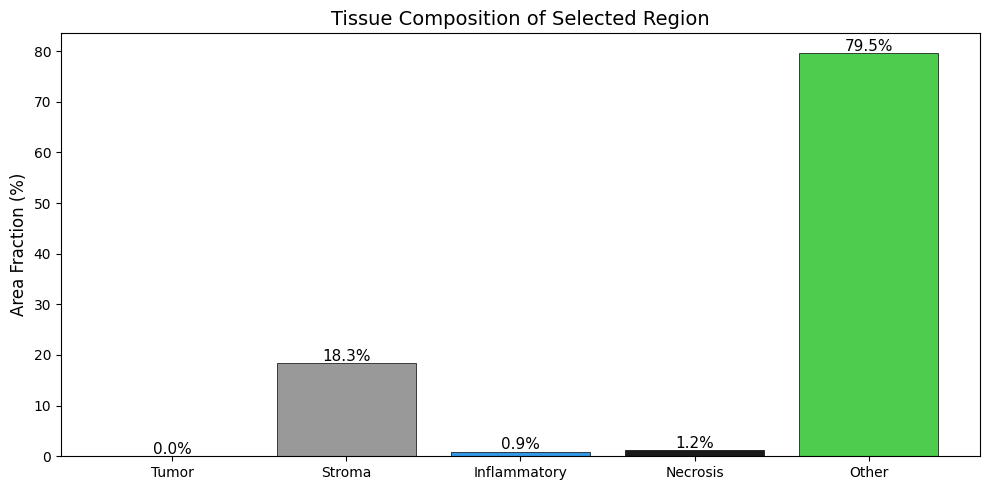

In [ ]:
# Calculate area fractions
total_pixels = seg_map.size
print("Tissue composition:")
print("-" * 35)

fractions = {}
for cls_id, cls_name in enumerate(bcss_classes):
    count = (seg_map == cls_id).sum()
    fraction = count / total_pixels * 100
    fractions[cls_name] = fraction
    print(f"  {cls_name:15s}: {fraction:6.1f}%")

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
colors = [bcss_colors[i] for i in range(len(bcss_classes))]
bars = ax.bar(bcss_classes, fractions.values(), color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel("Area Fraction (%)", fontsize=12)
ax.set_title("Tissue Composition of Selected Region", fontsize=14)
for bar, val in zip(bars, fractions.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{val:.1f}%", ha='center', fontsize=11)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we learned how to:

- Use `SemanticSegmentor` with the pretrained `fcn_resnet50_unet-bcss` model for pixel-level tissue segmentation
- Extract a tissue tile from an IDC slide and run segmentation in **tile mode**
- Visualize segmentation results as colored maps and overlays
- Quantify tissue composition by calculating area fractions

**Key difference from Notebook 04:** Patch classification assigns one label per patch, while semantic segmentation assigns a label to every pixel, providing much finer spatial detail.

**Next:** [Notebook 06](06_nucleus_instance_segmentation.ipynb) demonstrates individual nucleus detection and classification with HoVer-Net.

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5
- **BCSS:** Amgad, M., et al. "Structured crowdsourcing enables convolutional segmentation of histology images." *Bioinformatics* 35.18 (2019). https://doi.org/10.1093/bioinformatics/btz083